In [1]:
import numpy as np
from numpy import random as rd

import numba as nb
import cupy as cp
from numba import cuda
from numba import vectorize

from scipy.fft import fft
from scipy.stats.distributions import chi2

# useful but not essential:
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")

In [2]:
# Stuff on CPU:
def ord_CSM(sinal, tamanhoJanela, M):
    sinal = np.reshape(sinal[0:tamanhoJanela*M], (M,tamanhoJanela))

    FFT_SINAL = fft(sinal).transpose()
    angulo = np.angle(FFT_SINAL)

    s = ((1/M)*(np.sum(np.sin(np.unwrap(angulo)),1)))**2
    c = ((1/M)*(np.sum(np.cos(np.unwrap(angulo)),1)))**2

    CSM =  c+s

    return [FFT_SINAL,CSM]

def vc_CSM(M, alpha = 0.05, VERBOSE=0):
    vc = chi2.ppf(1-alpha,2)/(2*M)
    
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico CSM: ',vc)

    return vc


def senoide(amplitude = 1, theta0 = 0,f0 = 100, fs = 1000, N = -1,M = -1,tj = -1,cosseno = -1):

    fl = 2*np.pi*f0/fs    

    if M>0 and tj>0: N = M*tj

    t = np.linspace(0,N-1,num=N)
    arg = fl*t

    if cosseno<0: sinal = amplitude*np.sin(arg +theta0)
    else: sinal = amplitude*np.cos(arg +theta0)

    return sinal

Simulando: 100%|██████████| 10000/10000 [01:53<00:00, 88.39it/s]


Probabilidade de detecção atingida: 100.0%
(PD esperada =  95.0%)
Detectou?  True


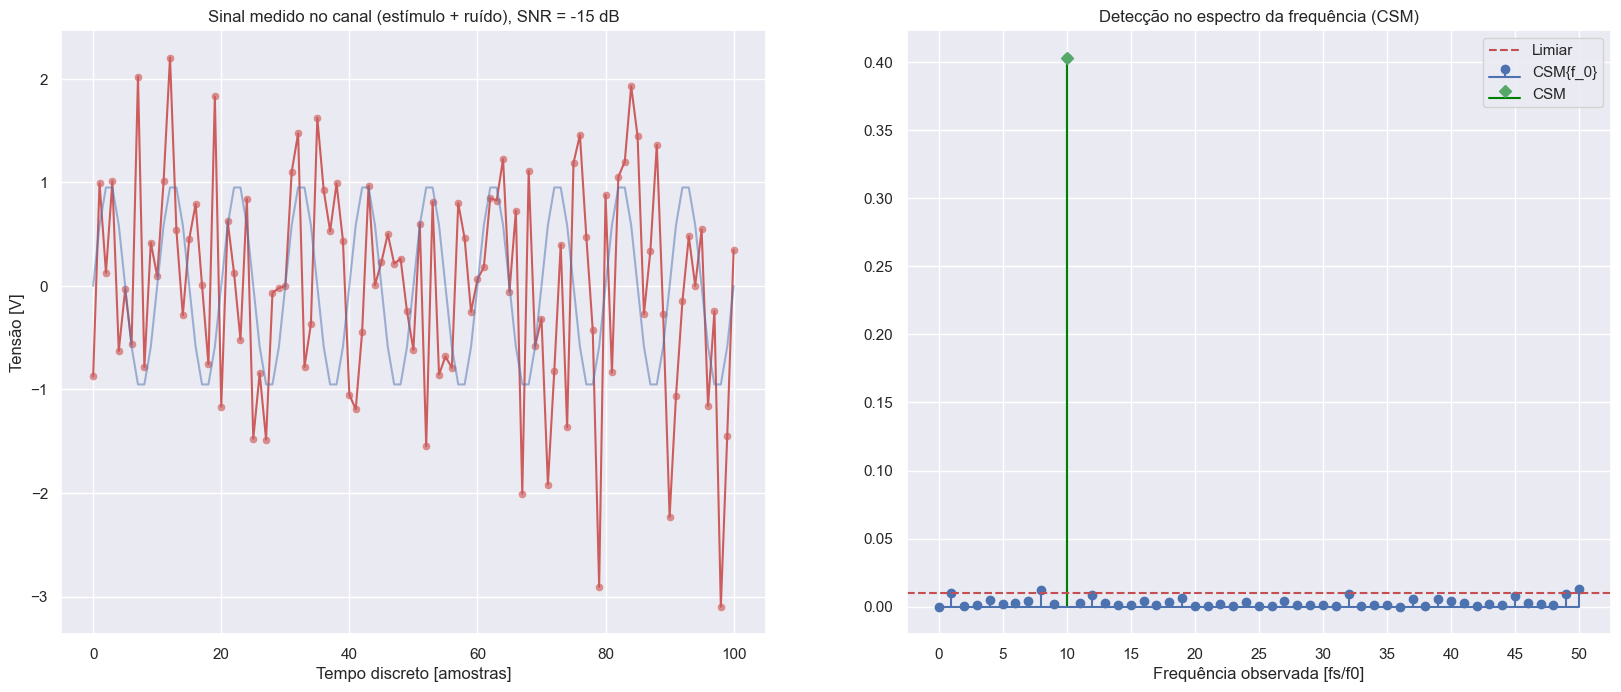

In [3]:

nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)

# Calcula senóide base:
f0 = 100
fs = 1000
M = 300 # número de janelas até o teste
tj = 100 # 1 seg/jan
N = M*tj # num. de pontos na senóide
x = senoide(amplitude=1, N=N, f0 = f0, fs=fs)
alpha = 0.05

amplitudeRuido = 0
energia_ruido = 1
SNRi = -15
A = 10**(SNRi/20)*(energia_ruido**2);
limiar = vc_CSM(M=M) # alpha = 5%
nd  = 0

for i in tqdm(range(0,nSim), desc = 'Simulando'):
    # Soma ruido aleatório novo à senóide inicial, em cada simulação:
    A = 10**(SNRi/20)*(energia_ruido**2);
    ruido =  amplitudeRuido+ energia_ruido*rd.randn(N,)
    sinal = A*x  + ruido
    
    # Calcula SFT na f0:
    [_, ORD]= ord_CSM(sinal = sinal, tamanhoJanela=tj, M= M)

    # Detecção?
    bin_f0 = round(len(ORD)*f0/fs)
    if  ORD[bin_f0] > limiar: nd +=1


print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')
print('(PD esperada = ',100*(1-alpha),'\b%)')

fig2 = plt.subplot(121);
sns.scatterplot(data = sinal[0:101], color='indianred', alpha = 0.65);
sns.lineplot(data = sinal[0:101], color='indianred');
sns.lineplot(data = x[0:101], color='b', alpha = 0.5);
titulo = 'Sinal medido no canal (estímulo + ruído), SNR = '+str(SNRi)+' dB'
plt.title(titulo);
plt.xlabel('Tempo discreto [amostras]');
plt.ylabel('Tensão [V]');

plt.subplot(122);
# print(fs/f0) # ORD está na frequencia observada (fl = fs/f0)
plt.stem(ORD[0:round(len(ORD)/2 +1)], linefmt= 'b', basefmt= 'b');
plt.stem(bin_f0, ORD[bin_f0], markerfmt='gD' ,linefmt= 'green',basefmt= 'green')
plt.axhline(y=limiar, color='r', linestyle = '--');
plt.title('Detecção no espectro da frequência (CSM)');
plt.xlabel('Frequência observada [fs/f0]');
plt.xticks(np.arange(0,round(len(ORD)/2 +len(ORD)/20), len(ORD)/20))
plt.legend(['Limiar','CSM{f_0}','CSM'])

# plt.legend('CSM','Limiar');

print('Detectou? ', ORD[bin_f0] > limiar)
# Altere a amplitude do ruido para observar o efeito :)

In [28]:
# cp.reshape(,(2,2))
# print(cp.ndarray([1,2,3,4]))

In [10]:
# Stuff on GPU:
import cupyx.scipy.fft as cufft

# @cuda.jit(device=True)
# def componente_sen()

# @cuda.jit(device=True)
# def componente_cos()
# @vectorize(['float32(float32, float32, float32)'], target='cuda', nopython= True)
# @cuda.jit(device=True)

@vectorize(['float64(float64, float64)'], target='cuda')
def add_ufunc(x, y):
    return x + y

# @vectorize(['float64(float64, float64)'], target='cuda')
# def sen_comp(ang,M):
    # return ((1/M)*(cp.sum(cp.sin(ang),1)))**2

# @cuda.jit(device=True)
# def aux_ufunc(sinal, tamanhoJanela, M):
#     sinal = np.reshape(sinal[0:tamanhoJanela*M], (M,tamanhoJanela))

#     FFT_SINAL = cufft.fft(sinal).transpose()
#     angulo = np.angle(FFT_SINAL)

#     s = ((1/M)*(np.sum(np.sin(np.unwrap(angulo)),1)))**2
#     c = ((1/M)*(np.sum(np.cos(np.unwrap(angulo)),1)))**2

#     return c,s



# @cuda.jit(device=True)
# def aux_ufunc(sinal, tamanhoJanela, M):
#     sinal = np.reshape(sinal[0:tamanhoJanela*M], (M,tamanhoJanela))

#     FFT_SINAL = cufft.fft(sinal).transpose()
#     angulo = np.angle(FFT_SINAL)

#     s = ((1/M)*(np.sum(np.sin(np.unwrap(angulo)),1)))**2
#     c = ((1/M)*(np.sum(np.cos(np.unwrap(angulo)),1)))**2

#     # c,s = aux_ufunc(sinal, tamanhoJanela, M)
#     # CSM =  c+s

#     # return [CSM]
#     return c,s

# @vectorize(['float64(float64,float64,float64)'], target='cuda')
# def GPU_ord_CSM(sinal, tamanhoJanela, M):
#     c,s = aux_ufunc(sinal, tamanhoJanela, M)
#     return c+s

@nb.jit(parallel= True, fastmath=True)
def cpu_ord_CSM(sinal, tamanhoJanela, M):
    sinal = cp.reshape(sinal, (M,tamanhoJanela))

    FFT_SINAL = cufft.fft(sinal).transpose()
    angulo = cp.angle(FFT_SINAL)

    s = ((1/M)*(cp.sum(cp.sin(cp.unwrap(angulo)),1)))**2
    # s = sen_comp(angulo,M);
    c = ((1/M)*(cp.sum(cp.cos(cp.unwrap(angulo)),1)))**2

    # CSM =  add_ufunc(c,s)
    CSM = c+s

    return [FFT_SINAL,CSM]

C:\Users\alexa\AppData\Local\Programs\Python\Python38\lib\site-packages\numba\cuda\decorators.py:110: NumbaDeprecationWarning: Eager compilation of device functions is deprecated (this occurs when a signature is provided)
  warn(NumbaDeprecationWarning(msg))


Simulando: 100%|██████████| 10000/10000 [00:45<00:00, 221.02it/s]


Probabilidade de detecção atingida: 87.72999999999999%
(PD esperada =  95.0%)
Detectou?  True


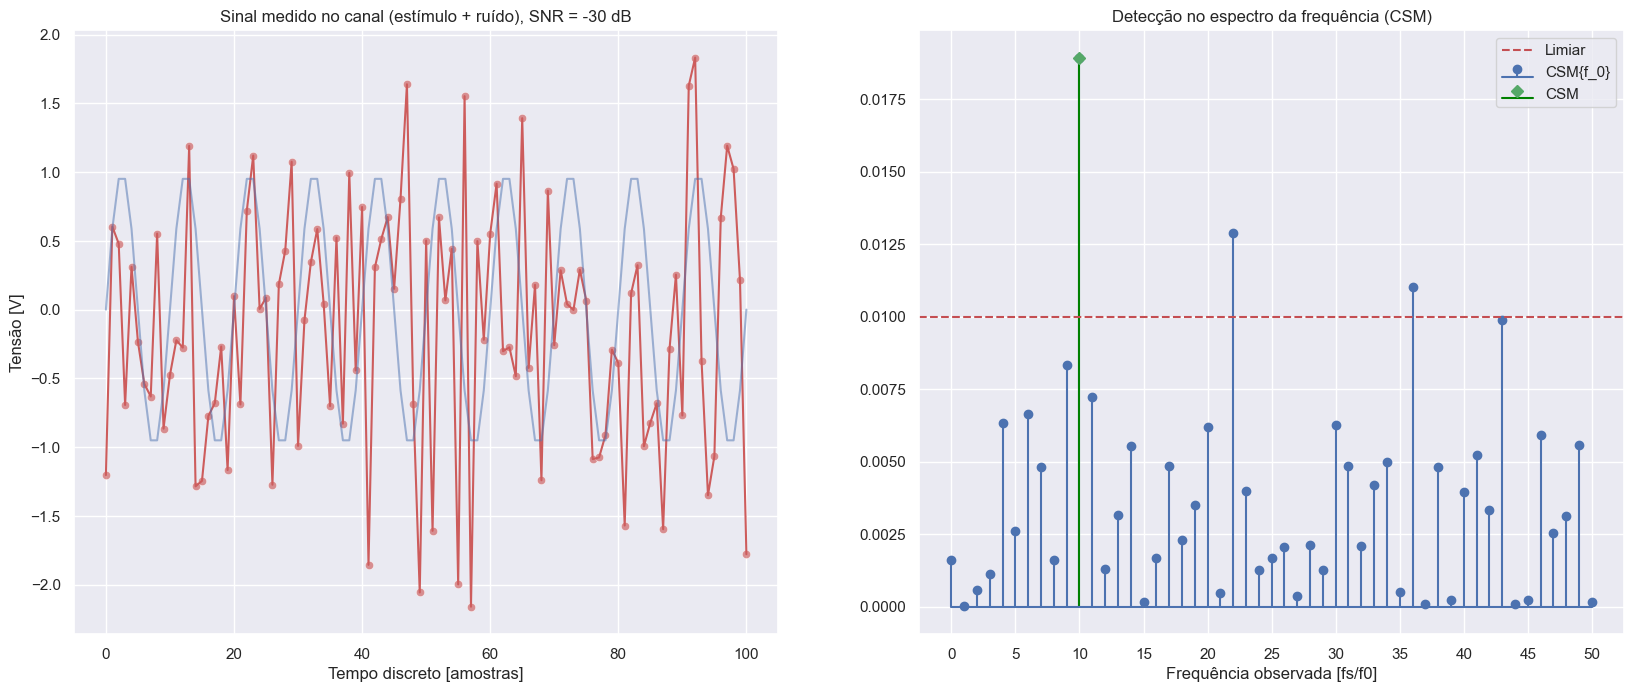

In [14]:
nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)

# Calcula senóide base:
f0 = 100
fs = 1000
M = 300 # número de janelas até o teste
tj = 100 # 1 seg/jan
N = M*tj # num. de pontos na senóide
x = senoide(amplitude=1, N=N, f0 = f0, fs=fs)
alpha = 0.05

amplitudeRuido = 0
energia_ruido = 1
SNRi = -30
A = 10**(SNRi/20)*(energia_ruido**2);
limiar = vc_CSM(M=M) # alpha = 5%
nd  = 0

# @nb.jit(parallel=True)
# def simula(nSim, A,SNRi, energia_ruido,x,nd,f0, fs,N,tj,M,limiar):
for _ in tqdm(range(0,nSim), desc = 'Simulando'):
    # Soma ruido aleatório novo à senóide inicial, em cada simulação:
    A = 10**(SNRi/20)*(energia_ruido**2);
    ruido =  amplitudeRuido+ energia_ruido*rd.randn(N,)
    sinal = A*x  + ruido
    
    # Calcula CSM:
    # with cp.cuda.Device(0):
        # [_,ORD] = cpu_ord_CSM(sinal = cp.asarray(sinal), tamanhoJanela=tj, M= M)
    [_,ORD] = cpu_ord_CSM(sinal = cp.asarray(sinal[0:tj*M]), tamanhoJanela=tj, M= M)
    
    # Detecção?
    bin_f0 = round(len(ORD)*f0/fs)
    if  ORD[bin_f0] > limiar: nd +=1
    # return ORD, nd

# [ORD,nd] = simula(nSim, A,SNRi, energia_ruido,x,nd,f0, fs,N,tj,M,limiar)
ORD = cp.asnumpy(ORD)

print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')
print('(PD esperada = ',100*(1-alpha),'\b%)')

fig2 = plt.subplot(121);
sns.scatterplot(data = sinal[0:101], color='indianred', alpha = 0.65);
sns.lineplot(data = sinal[0:101], color='indianred');
sns.lineplot(data = x[0:101], color='b', alpha = 0.5);
titulo = 'Sinal medido no canal (estímulo + ruído), SNR = '+str(SNRi)+' dB'
plt.title(titulo);
plt.xlabel('Tempo discreto [amostras]');
plt.ylabel('Tensão [V]');

plt.subplot(122);
# print(fs/f0) # ORD está na frequencia observada (fl = fs/f0)
plt.stem(ORD[0:round(len(ORD)/2 +1)], linefmt= 'b', basefmt= 'b');
plt.stem(bin_f0, ORD[bin_f0], markerfmt='gD' ,linefmt= 'green',basefmt= 'green')
plt.axhline(y=limiar, color='r', linestyle = '--');
plt.title('Detecção no espectro da frequência (CSM)');
plt.xlabel('Frequência observada [fs/f0]');
plt.xticks(np.arange(0,round(len(ORD)/2 +len(ORD)/20), len(ORD)/20))
plt.legend(['Limiar','CSM{f_0}','CSM'])

# plt.legend('CSM','Limiar');

print('Detectou? ', ORD[bin_f0] > limiar)
# Altere a amplitude do ruido para observar o efeito :)

In [ ]:
# cp.asarray(sinal).device
# cp.cuda.Memory
# cp.get_default_memory_pool()
# cp.cuda.runtime.driverGetVersion()
# cp.cuda.runtime.getDeviceCount()
# cp.cuda.runtime.memGetInfo()

# cp.cuda.runtime.getDeviceProperties(0)

{'name': b'NVIDIA GeForce GTX 1650',
 'totalGlobalMem': 4294967296,
 'sharedMemPerBlock': 49152,
 'regsPerBlock': 65536,
 'warpSize': 32,
 'maxThreadsPerBlock': 1024,
 'maxThreadsDim': (1024, 1024, 64),
 'maxGridSize': (2147483647, 65535, 65535),
 'clockRate': 1560000,
 'totalConstMem': 65536,
 'major': 7,
 'minor': 5,
 'textureAlignment': 512,
 'texturePitchAlignment': 32,
 'multiProcessorCount': 16,
 'kernelExecTimeoutEnabled': 1,
 'integrated': 0,
 'canMapHostMemory': 1,
 'computeMode': 0,
 'maxTexture1D': 131072,
 'maxTexture2D': (131072, 65536),
 'maxTexture3D': (16384, 16384, 16384),
 'concurrentKernels': 1,
 'ECCEnabled': 0,
 'pciBusID': 1,
 'pciDeviceID': 0,
 'pciDomainID': 0,
 'tccDriver': 0,
 'memoryClockRate': 4001000,
 'memoryBusWidth': 128,
 'l2CacheSize': 1048576,
 'maxThreadsPerMultiProcessor': 1024,
 'isMultiGpuBoard': 0,
 'cooperativeLaunch': 1,
 'cooperativeMultiDeviceLaunch': 0,
 'deviceOverlap': 1,
 'maxTexture1DMipmap': 32768,
 'maxTexture1DLinear': 268435456,
 'ma

In [121]:
# @cuda.jit(device=True)
# def GPU_ord_CSM(sinal, tamanhoJanela, M):
#     sinal = np.reshape(sinal[0:tamanhoJanela*M], (M,tamanhoJanela))

#     FFT_SINAL = cufft.fft(sinal).transpose()
#     angulo = np.angle(FFT_SINAL)

#     s = ((1/M)*(np.sum(np.sin(np.unwrap(angulo)),1)))**2
#     c = ((1/M)*(np.sum(np.cos(np.unwrap(angulo)),1)))**2

#     return c,s

# @vectorize(['float64(float64,float64,float64)'], target='cuda')
# def aux_ufunc(sinal, tamanhoJanela, M):
#     c,s = GPU_ord_CSM(sinal, tamanhoJanela, M)
#     return c+s


# @vectorize(['float64(float64,float64,float64)'], target='cuda')
@nb.jit(parallel=True)
def GPU_ord_CSM(sinal, tamanhoJanela, M):
    sinal = cp.reshape(sinal[0:tamanhoJanela*M], (M,tamanhoJanela))

    FFT_SINAL = cufft.fft(sinal).transpose()
    angulo = cp.angle(FFT_SINAL)

    s = ((1/M)*(cp.sum(cp.sin(cp.unwrap(angulo)),1)))**2
    c = ((1/M)*(cp.sum(cp.cos(cp.unwrap(angulo)),1)))**2

    return c+s


In [130]:
import pandas as pd
# Cerca de 15mins em média de simulação (24GB RAM, i5 8gen)
nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)

# Calcula senóide base:
f0 = 100
fs = 1000
M = 300 # número de janelas até o teste
tj = 100 # 1 seg/jan
N = M*tj # num. de pontos na senóide
x = senoide(amplitude=1, N=N, f0 = f0, fs=fs)
limiar = vc_CSM(M=M) # alpha = 5%

amplitudeRuido = 0
energia_ruido = 1
listaSNRs = np.arange(-60,-10,2)
probDetecCSM = np.zeros((len(listaSNRs),1))
nd  = 0

for i in tqdm(range(0,len(listaSNRs)), desc = 'Simulando'):
    SNRi = listaSNRs[i]; nd = 0;
    A = 10**(SNRi/20)*(energia_ruido**2);
    
    for _ in range(0,nSim):
        # Soma ruido aleatório novo à senóide inicial, em cada simulação:
        ruido =  amplitudeRuido+ energia_ruido*rd.randn(N,)
        sinal = A*x  + ruido

        # Calcula SFT na f0:
        [_,ORD] = cpu_ord_CSM(sinal = cp.asarray(sinal), tamanhoJanela=tj, M= M)

        # Detecção?
        bin_f0 = round(len(ORD)*f0/fs)
        if  ORD[bin_f0] > limiar: nd +=1

    probDetecCSM[i] = nd/nSim
    # print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')

pDCSM = pd.DataFrame({'SNR': listaSNRs,'Probabilidade de Detecção [%]':probDetecCSM[:,0]})
sns.lineplot(data = pDCSM,x='SNR',y='Probabilidade de Detecção [%]');
plt.title('Curva PD da CSM');
# pDCSM.to_csv('PD_CSM.csv')

Simulando:   4%|▍         | 1/25 [00:34<13:48, 34.51s/it]


KeyboardInterrupt: 